In [1]:
# Importing libraries
import numpy as np
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("borhanitrash/animal-image-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 38.4M/38.4M [00:00<00:00, 202MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/borhanitrash/animal-image-classification-dataset/versions/1


In [3]:
path

'/root/.cache/kagglehub/datasets/borhanitrash/animal-image-classification-dataset/versions/1'

In [6]:
path = path+'/Animals/'

import os

os.listdir(path)

['cats', 'dogs', 'snakes']

In [7]:
# Directory path to the training data
data_dir = pathlib.Path(path)

In [8]:
data_dir

PosixPath('/root/.cache/kagglehub/datasets/borhanitrash/animal-image-classification-dataset/versions/1/Animals')

In [9]:
# Count the total number of image files within the "input/Training_data/" directory and its subdirectories
image_count = len(list(data_dir.glob('*/*')))

print(image_count)

3000


In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
# Create a training dataset using TensorFlow's image_dataset_from_directory function
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                  # The directory containing the image data
    validation_split=0.2,      # Split 20% of the data for validation
    subset="training",         # Use the subset "training" for the training dataset
    seed=123,                  # Set the random seed to ensure data consistency
    image_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size      # Use a batch size of 'batch_size' for the training dataset
)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [12]:
# Create a validation dataset using TensorFlow's image_dataset_from_directory function
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                  # The directory containing the image data
    validation_split=0.2,      # Split 20% of the data for validation
    subset="validation",       # Use the subset "validation" for the validation dataset
    seed=123,                  # Set the random seed to ensure data consistency
    image_size=(img_height, img_width),  # Resize images to the specified dimensions
    batch_size=batch_size      # Use a batch size of 'batch_size' for the validation dataset
)

Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [13]:
# Displaying classes
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs', 'snakes']


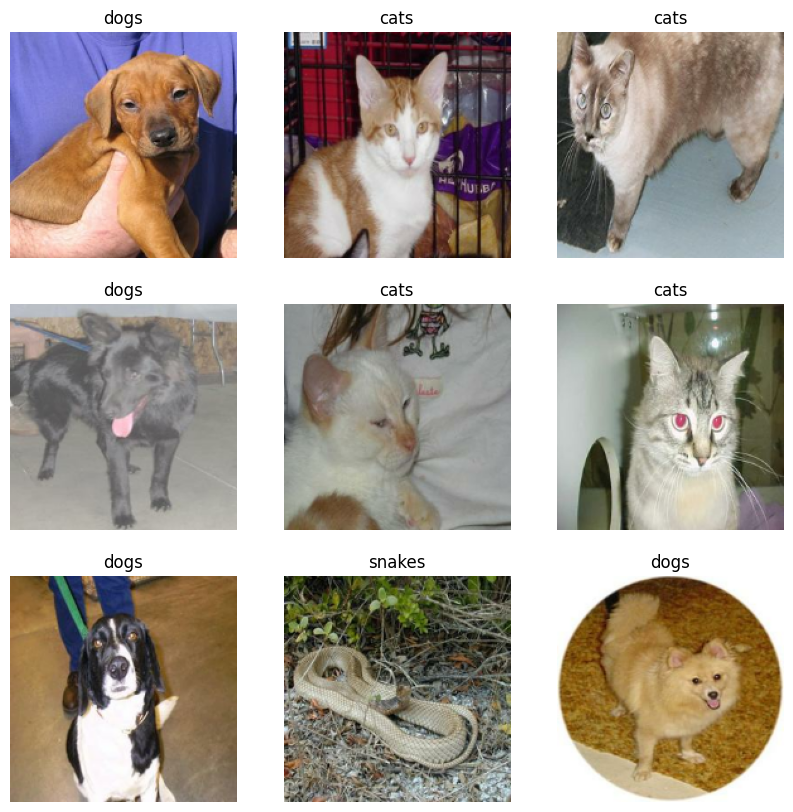

In [14]:
import matplotlib.pyplot as plt

# Create a new figure with a specified size
plt.figure(figsize=(10, 10))

# Loop through the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Iterate through the first 9 images in the batch
    for i in range(9):
        # Create a subplot within the 3x3 grid
        ax = plt.subplot(3, 3, i + 1)

        # Display the image as a plot and convert it to uint8 format
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the corresponding class name
        plt.title(class_names[labels[i]])

        # Turn off the axis to remove axis labels
        plt.axis("off")


plt.show()

In [15]:
# Loop through batches of images and labels in the training dataset

for image_batch, labels_batch in train_ds:
    # Print the shape of the current image batch
    print(image_batch.shape)

    # Print the shape of the current label batch
    print(labels_batch.shape)

    break

(32, 180, 180, 3)
(32,)


In [16]:
# Define AUTOTUNE to utilize TensorFlow's automatic optimization
AUTOTUNE = tf.data.AUTOTUNE

# Cache, shuffle, and prefetch the training dataset for improved performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch the validation dataset for improved performance
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# Create a Rescaling layer to normalize pixel values to the range [0, 1]
normalization_layer = layers.Rescaling(1./255)

In [18]:
# Apply the normalization layer to the training dataset using the map function
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Extract the first batch of images and labels from the normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# Get the first image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first image
# Notice that the pixel values are now in the [0, 1] range.
print(np.min(first_image), np.max(first_image))

0.0014335798 0.98834765


In [19]:
# Calculate the number of classes based on the class names
num_classes = len(class_names)

# Create a Sequential model for image classification
model = Sequential([
  # Rescale the input image pixel values to the [0, 1] range
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Convolutional layer with 16 filters, ReLU activation, and 'same' padding
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),

  # Convolutional layer with 32 filters, ReLU activation, and 'same' padding
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),

  # Convolutional layer with 64 filters, ReLU activation, and 'same' padding
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),

  # Flatten layer to convert 2D feature maps to a 1D vector
  layers.Flatten(),

  # Fully connected dense layer with 128 units and ReLU activation
  layers.Dense(128, activation='relu'),

  # Output layer with units equal to the number of classes
  layers.Dense(num_classes)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Compile the Keras model with the optimizer, loss function, and metrics
model.compile(
    optimizer='adam',  # Use the Adam optimizer for training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Specify the loss function
    metrics=['accuracy']  # Monitor accuracy as a metric during training
)

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Set the number of training epochs
epochs = 20

# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs  # Number of training epochs
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3935 - loss: 1.1492 - val_accuracy: 0.6300 - val_loss: 0.7392
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6482 - loss: 0.7548 - val_accuracy: 0.6633 - val_loss: 0.6645
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7016 - loss: 0.6242 - val_accuracy: 0.6767 - val_loss: 0.6948
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7470 - loss: 0.5779 - val_accuracy: 0.7200 - val_loss: 0.6612
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8225 - loss: 0.4404 - val_accuracy: 0.7067 - val_loss: 0.7420
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8843 - loss: 0.2980 - val_accuracy: 0.7333 - val_loss: 0.7396
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9295 - loss: 0.2059 - val_accuracy: 0.7000 - val_loss: 0.9132
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9658 - loss: 0.1179 - val_accuracy: 0.6950 - val_loss:

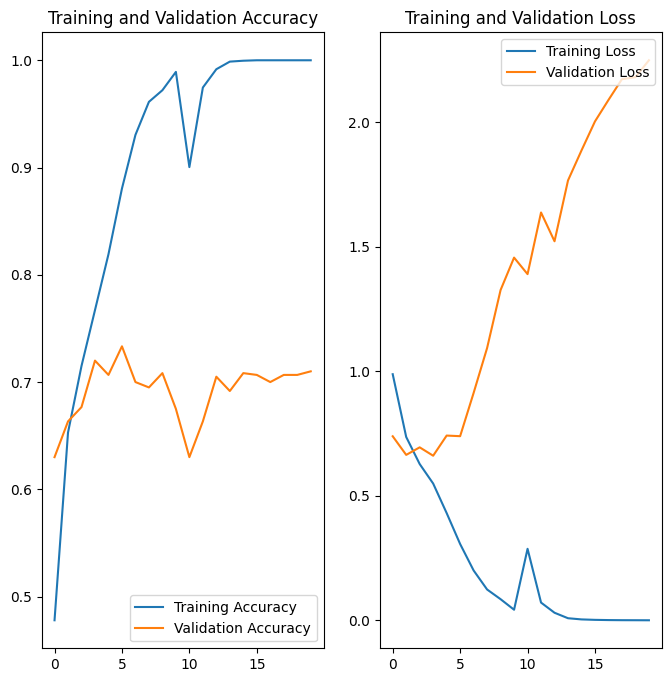

In [23]:
# Extract the training and validation accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualizations
plt.figure(figsize=(8, 8))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the complete figure with both subplots
plt.show()

In [24]:
# Create a data augmentation pipeline using a Keras Sequential model
data_augmentation = keras.Sequential(
  [
    # Randomly flip images horizontally
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),

    # Randomly rotate images by a maximum of 0.1 radians
    layers.RandomRotation(0.1),

    # Randomly zoom images in or out by a maximum of 0.1 times
    layers.RandomZoom(0.1),
  ]
)

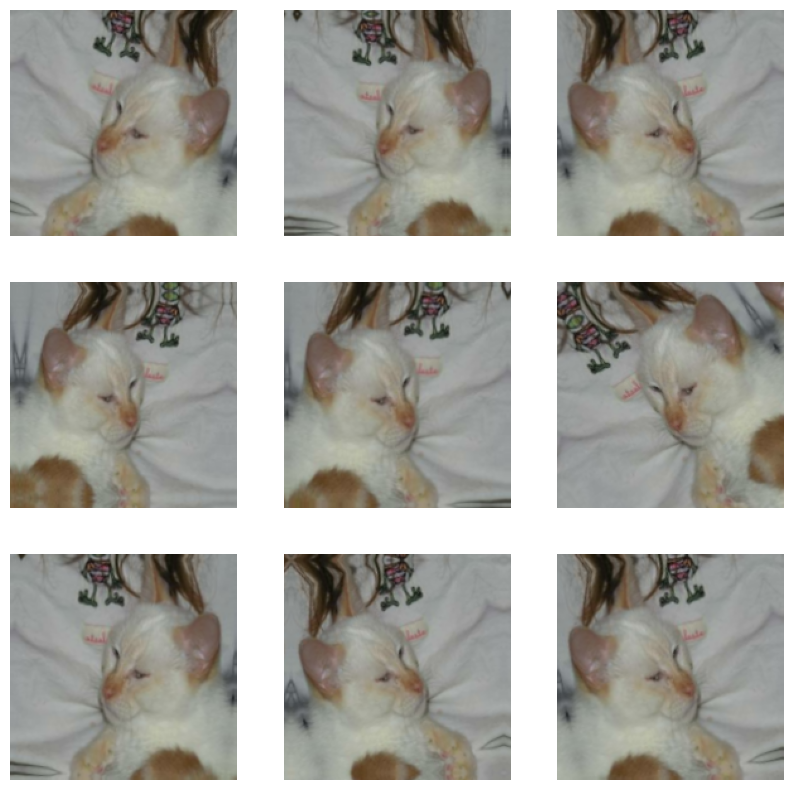

In [25]:
# Create a figure for visualizing augmented images
plt.figure(figsize=(10, 10))

# Loop through the first batch of images from the training dataset
for images, _ in train_ds.take(1):
    # Iterate through the first 9 images
    for i in range(9):
        # Apply data augmentation to the images in the batch
        augmented_images = data_augmentation(images)

        # Create a subplot within the 3x3 grid
        ax = plt.subplot(3, 3, i + 1)

        # Display the augmented image as a plot and convert it to uint8 format
        plt.imshow(augmented_images[0].numpy().astype("uint8"))

        # Turn off the axis to remove axis labels
        plt.axis("off")

In [26]:
# Create a Sequential model for image classification with data augmentation
model = Sequential([
  # Data augmentation pipeline defined earlier
  data_augmentation,

  # Rescale the input image pixel values to the [0, 1] range
  layers.Rescaling(1./255),

  # Convolutional layer with 16 filters, ReLU activation, and 'same' padding
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),

  # Convolutional layer with 32 filters, ReLU activation, and 'same' padding
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),

  # Convolutional layer with 64 filters, ReLU activation, and 'same' padding
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  # Max-pooling layer to downsample the feature maps
  layers.MaxPooling2D(),

  # Dropout layer to prevent overfitting
  layers.Dropout(0.2),

  # Flatten layer to convert 2D feature maps to a 1D vector
  layers.Flatten(),

  # Fully connected dense layer with 128 units and ReLU activation
  layers.Dense(128, activation='relu'),

  # Output layer with units equal to the number of classes
  layers.Dense(num_classes)
])

In [27]:
# Compile the Keras model with the optimizer, loss function, and metrics
model.compile(
    optimizer='adam',  # Use the Adam optimizer for training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Specify the loss function
    metrics=['accuracy']  # Monitor accuracy as a metric during training
)

In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,027 (15.22 MB)

 Trainable params: 3,989,027 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Set the number of training epochs
epochs = 30

# Train the model using the training dataset and validate using the validation dataset
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs  # Number of training epochs
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.4560 - loss: 1.0538 - val_accuracy: 0.4817 - val_loss: 1.1580
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6329 - loss: 0.7921 - val_accuracy: 0.5583 - val_loss: 0.9645
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.6498 - loss: 0.7293 - val_accuracy: 0.6817 - val_loss: 0.6927
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.6673 - loss: 0.7087 - val_accuracy: 0.6183 - val_loss: 0.9287
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6953 - loss: 0.6800 - val_accuracy: 0.6883 - val_loss: 0.6930
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6816 - loss: 0.7034 - val_accuracy: 0.6633 - val_loss: 0.7974
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7021 - loss: 0.6637 - val_accuracy: 0.5133 - val_loss: 1.4786
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6884 - loss: 0.6784 - val_accuracy: 0.7117 - val_

In [33]:
model.save("/content/drive/MyDrive/Python Projects/My Projects/Animal classification using CNN/cnn-model.h5")

In [34]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Python Projects/My Projects/Animal classification using CNN/cnn-model.h5")

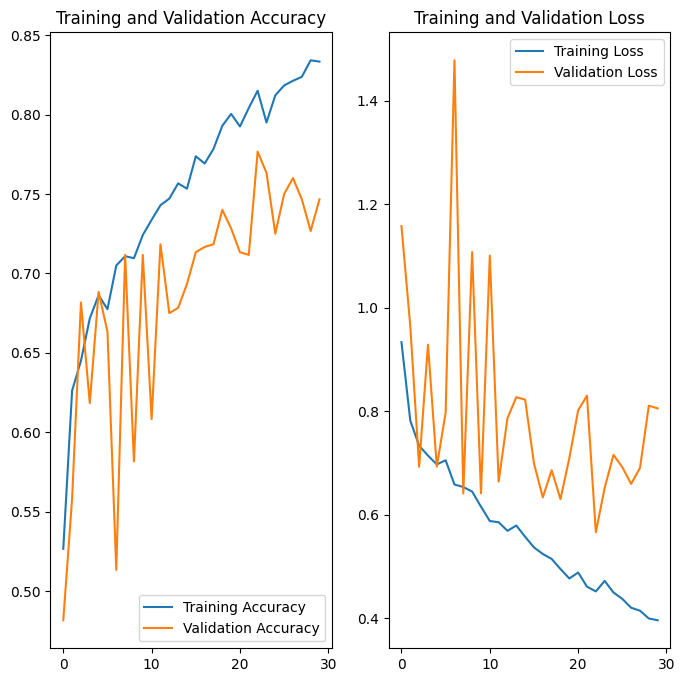

In [36]:
# Extract the training and validation accuracy and loss values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs_range = range(epochs)

# Create a figure with two subplots for accuracy and loss visualizations
plt.figure(figsize=(8, 8))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show the complete figure with both subplots
plt.show()

# Prediction

In [46]:
import os

os.listdir(path)

['cats', 'dogs', 'snakes']

In [47]:
img_path = path+'/cats/0_0878.jpg'

In [48]:
# Load an image from the specified path and resize it to the target size
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

# Convert the image to a NumPy array
img_array = tf.keras.utils.img_to_array(img)

# Expand the dimensions of the array to create a batch
img_array = tf.expand_dims(img_array, 0)

In [49]:
# Make predictions on the input image using the trained model
predictions = model.predict(img_array)

# Apply the softmax function to the prediction scores
score = tf.nn.softmax(predictions[0])

# Print the predicted class label and confidence score
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
This image most likely belongs to cats with a 89.01 percent confidence.
